## Multiple Sequence Alignment

The aim of this notebook is to conduct a multiple sequence alignment (henceforth MSA). MSA methods refer to a series of algorithmic solution for the alignment of evolutionarily related sequences, while taking into account evolutionary events such as mutations, insertions, deletions and rearrangements under certain conditions. These methods can be applied to DNA, RNA or protein sequences. (https://academic.oup.com/bib/article/17/6/1009/2606431)
We will use the files of XML format (`curated_uniprot.fasta_`) with the information of hsp regions and the amino acid sequences.

In [1]:
# Importing the libraries and functions
from functions import *

### 1. Data Preparation

We have defined a function that parses an XML file with the BLAST alignment into a pandas dataframe. This function can be utilized to include any additional columns from the BLAST results.

In [2]:
# Keep only disordered regions in the initial dataframe filtering using curated_disordered dataframe
disordered = pd.read_csv("disordered_df.csv")
print(f"The number of rows containing disordered regions: {len(disordered)}")
disordered.head(5)

The number of rows containing disordered regions: 2887


,query_id,subject_id,query_len,hsp_len,query_seq,match_seq,subject_seq,query_start,query_end,subject_start,subject_end,identity,positive,gaps,eval,bit_score,count
0,Q9H832,A0A6J2FM24,354,356,MAESPTEEAATA--GAGAAGPGASSVAGVVGVSGSGGGFGPPFLPD...,MAESPTEEAATA GAGAAGPGAS V GVVGVSGSG FGPPFLPD...,MAESPTEEAATATAGAGAAGPGASGVTGVVGVSGSG--FGPPFLPD...,1,354,1,354,350,350,4,0.0,1851.0,200
1,Q9H832,A0A3Q7W6Y2,354,356,MAESPTEEAATA--GAGAAGPGASSVAGVVGVSGSGGGFGPPFLPD...,MAESPTEEAATA GAGA GPGAS VAGVVGVSGSG FGPPFLPD...,MAESPTEEAATATAGAGATGPGASGVAGVVGVSGSG--FGPPFLPD...,1,354,1,354,350,350,4,0.0,1851.0,200
2,Q9H832,A0A2U3VK69,354,356,MAESPTEEAATA--GAGAAGPGASSVAGVVGVSGSGGGFGPPFLPD...,MAESPTEEAATA GAGAAGPGAS V GVVGVSGSG FGPPFLPD...,MAESPTEEAATATAGAGAAGPGASGVTGVVGVSGSG--FGPPFLPD...,1,354,1,354,350,350,4,0.0,1851.0,200
3,Q9H832,A0A2Y9JVH5,354,358,MAESPTEEAATA----GAGAAGPGASSVAGVVGVSGSGGGFGPPFL...,MAESPTEEAATA GAGAAGPGAS VAGVVGVSGSG FGPPFL...,MAESPTEEAATATATAGAGAAGPGASGVAGVVGVSGSG--FGPPFL...,1,354,1,356,351,351,6,0.0,1854.0,200
4,Q9H832,A0A8C7ALE4,354,358,MAESPTEEAATA----GAGAAGPGASSVAGVVGVSGSGGGFGPPFL...,MAESPTEEAATA GAGAAGPGAS VAGVVGVSGSG FGPPFL...,MAESPTEEAATATATAGAGAAGPGASGVAGVVGVSGSG--FGPPFL...,1,354,1,356,351,351,6,0.0,1854.0,200


The number of sequences containing disordered regions: 16


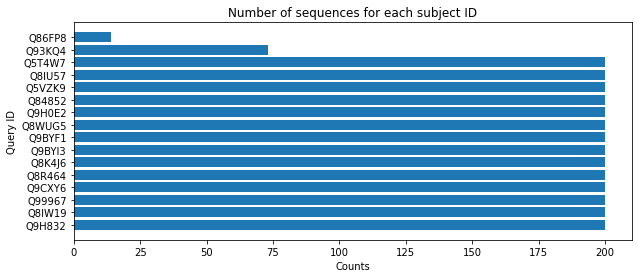

In [3]:
# Plot subject IDs count
figure(figsize=(10, 4))
plt.barh(disordered['query_id'], disordered['count'])
plt.xlabel('Counts')
plt.ylabel('Query ID')
plt.title('Number of sequences for each subject ID')
print(f"The number of sequences containing disordered regions: {disordered['query_id'].nunique()}")
plt.show()

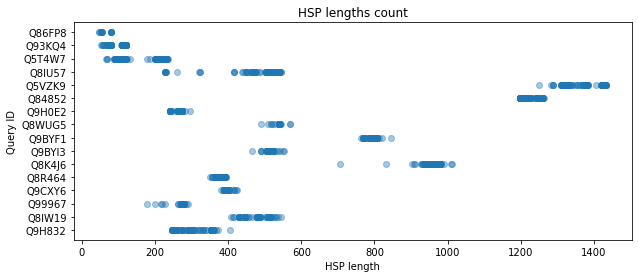

In [4]:
# Plot HSP length count
figure(figsize=(10, 4))
plt.scatter(disordered['hsp_len'], disordered['query_id'], alpha=0.4)
plt.xlabel('HSP length')
plt.ylabel('Query ID')
plt.title('HSP lengths count')
plt.show()

In [5]:
# Check if there are disordered regions for a particular query ID
%store -r id_dis
id = id_dis
selected_dis = disordered[disordered["query_id"].isin([id])]

# Filter the curated_disprot dataframe based on selected ID
curated_disprot = pd.read_csv("curated_disprot.csv")
curated_query = curated_disprot[curated_disprot['acc'] == id]
curated_query

,acc,evidence,feature,source,start,end,length
872,Q9H832,curated,disorder,disprot,1,99,99
873,Q9H832,curated,disorder,disprot,327,354,28


### 2. Query ID Analysis

Next, we determine the count of subject IDs for each query ID. It's important to note that we need to summarize the data for all subject IDs that occurred for a particular query, rather than for each individual 'query-sequence' pair.

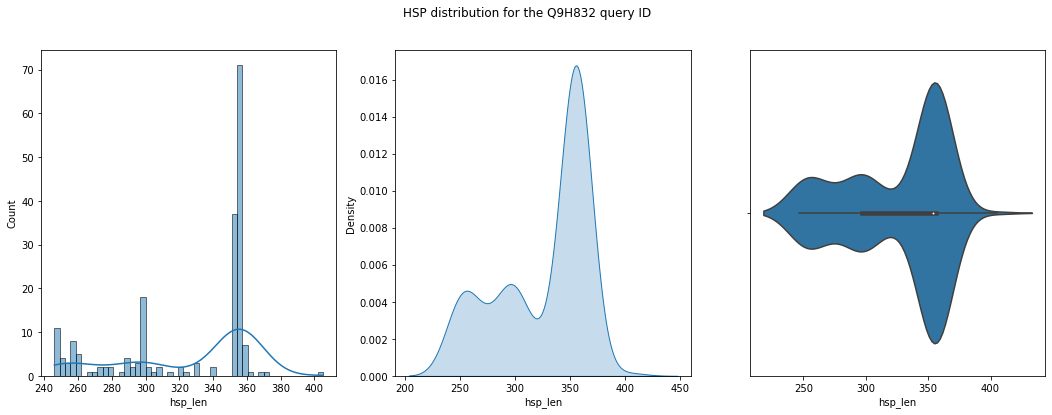

In [6]:
# Create bar plot for HSP hits of selected query ID
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
sns.histplot(selected_dis['hsp_len'], kde = True, bins = 50, ax = ax1)
sns.kdeplot(selected_dis['hsp_len'], shade = True, ax = ax2)
sns.violinplot(x = selected_dis['hsp_len'], ax = ax3)
plt.suptitle(f'HSP distribution for the {id} query ID')
plt.show()

The `histplot` shows the distribution of HSP lengths in the selected query ID by grouping the HSP lengths into bins or ranges along the x-axis and displaying the frequency of HSP lengths as the height of the corresponding bar on the y-axis.

The height of the `kdeplot` curve represents the estimated probability density of the variable being plotted at each point on the x-axis. For example, in the case of the HSP length, the height of the curve at a particular value of x represents the estimated density of observations around that value. The area under the curve represents the total probability of all possible values of the variable, which is equal to 1.

The `violinplot` provides the information about the interquartile range (thick gray line), median that is represented by a white dot and the rest of a distribution (thin gray line). The distribution's shape is presented on either side of the gray line through kernel density estimation. The wider sections of the violin plot represent a greater probability of the population taking on a specific value, while the narrower sections indicate a lower probability.

### 3. Multiple Sequence Alignment

Within this framework, we will compare the MSA results obtained directly from the BLAST output with those generated from the ClustalOmega service.

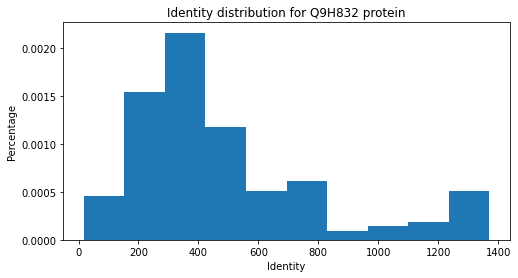

In [7]:
# Plot identity distribution
figure(figsize=(8, 4))
plt.hist(disordered['identity'], bins=10, density=True)  # Set density=True for percentage values
plt.xlabel('Identity')
plt.ylabel('Percentage')
plt.title(f'Identity distribution for {id} protein')
plt.show()

In [8]:
# Import numpy arrays of MSAs from BLAST, ClustalOmega and MAFFT
%store -r blast_seqs clustal_seqs mafft_seqs
# The number of sequences may differ
blast_seqs.shape, clustal_seqs.shape, mafft_seqs.shape

((201, 354), (199, 354), (199, 354))

#### Removing redundant regions

For this step we use the input files for ClustalOmega or MAFFT alignment. The goal is to keep only non-redundant regions. We set the threshold for redundancy of 62%. The program implementing the task is called `cd-hit`.

Next, we will be working with the newly generated file. It will be uploaded to ebi website, where we will select Pearson/FASTA as the output format. Once we have downloaded the aligned sequences, we can analyze the alignment using Jalview.

In [9]:
# Create a dataframe with the calculated redundancy
redundancy_df = pd.read_csv("nr_75.csv", sep=";")
redundancy_df

,id,len,non-red,ratio
0,Q9H832,199,2,"0,01"
1,Q8IW19,200,3,"0,02"
2,Q99967,198,3,"0,02"
3,Q9CXY6,200,1,"0,01"
4,Q8R464,200,2,"0,01"
5,Q8K4J6,198,1,"0,01"
6,Q9BYI3,198,3,"0,02"
7,Q9BYF1,199,2,"0,01"
8,Q8WUG5,199,3,"0,02"
9,Q9H0E2,200,1,"0,01"


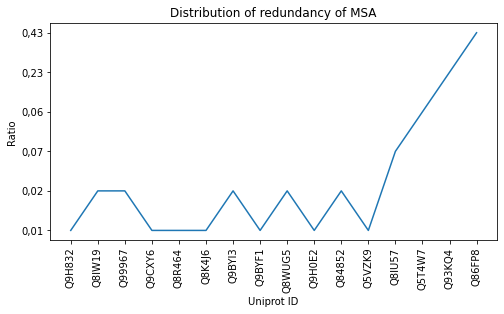

In [10]:
# Plot the redundancy distribution
figure(figsize=(8, 4))
plt.plot(redundancy_df['id'], redundancy_df['ratio'])
plt.xlabel("Uniprot ID")
plt.ylabel("Ratio")
plt.xticks(rotation='vertical')
plt.title("Distribution of redundancy of MSA")
plt.show()

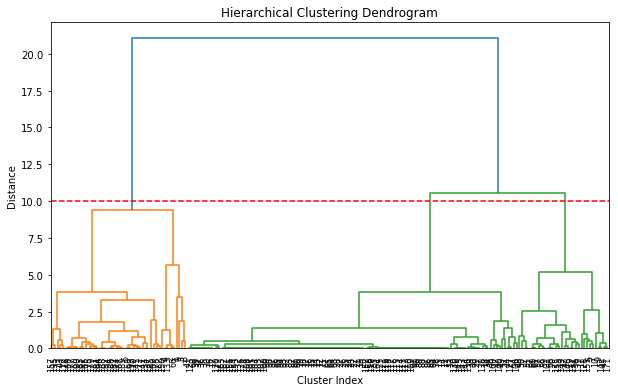

In [11]:
# Plot the dendrogram
%store -r data_file

cluster_data = []
with open(data_file, 'r') as file:
    for line in file:
        if line.startswith('>Cluster'):
            continue
        parts = line.strip().split('\t')
        percentage_matches = re.findall(r'\d+\.\d+', parts[-1])
        if percentage_matches:
            percentage = float(percentage_matches[0])
            cluster_data.append(percentage)

# Convert the data into a matrix
matrix_data = np.array(cluster_data).reshape(len(cluster_data), 1)

# Create linkage matrix using the data and hierarchical clustering
Z = linkage(matrix_data, method='average')

# Plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(Z, labels=np.arange(len(cluster_data)), leaf_rotation=90, leaf_font_size=8)

# Add a horizontal line for the threshold
threshold = 10.0
plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold ({threshold}%)')

plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Cluster Index')
plt.ylabel('Distance')
plt.show()

### 4. Analysing the quality of prediction

For calculation of the entropy we use a probability distribution with 20 outcomes, where each outcome has an equal probability of 1/20. Entropy is a measure of the uncertainty or randomness associated with a probability distribution. In this case, since the probability distribution is uniform, the entropy is maximized, meaning that there is maximum uncertainty or randomness associated with the outcomes.

With occupancy we define the proportion of non-missing (non-gap) values in the column.

### 4.1. Calculation of occupancy and entropy for initial MSA

In [12]:
# Calculate the occupancy and entropy for each type of MSA
blast_calc = stats_calculation(blast_seqs)
clustal_calc = stats_calculation(clustal_seqs)
mafft_calc = stats_calculation(mafft_seqs)

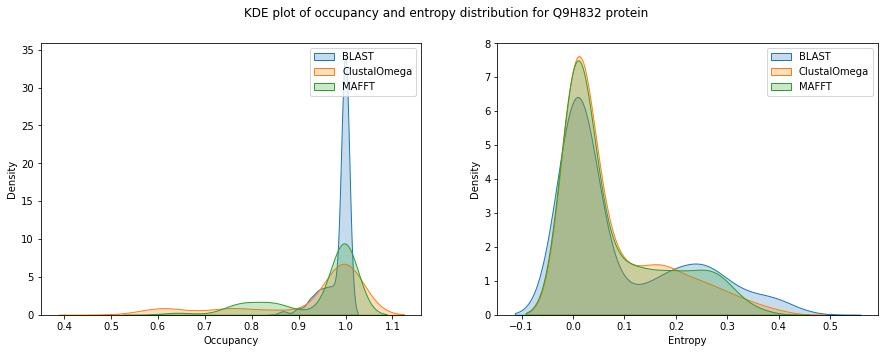

In [13]:
# KDE plot of occupancy/entropy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.kdeplot(blast_calc['occupancy'], shade = True, ax = ax1)
sns.kdeplot(clustal_calc['occupancy'], shade = True, ax = ax1)
sns.kdeplot(mafft_calc['occupancy'], shade = True, ax = ax1)

sns.kdeplot(blast_calc['entropy'], shade = True, ax = ax2)
sns.kdeplot(clustal_calc['entropy'], shade = True, ax = ax2)
sns.kdeplot(mafft_calc['entropy'], shade = True, ax = ax2)

ax1.legend(['BLAST', 'ClustalOmega', 'MAFFT'])
ax2.legend(['BLAST', 'ClustalOmega', 'MAFFT'])
ax1.set_xlabel('Occupancy')
ax2.set_xlabel('Entropy')
plt.suptitle(f'KDE plot of occupancy and entropy distribution for {id} protein')
plt.show()

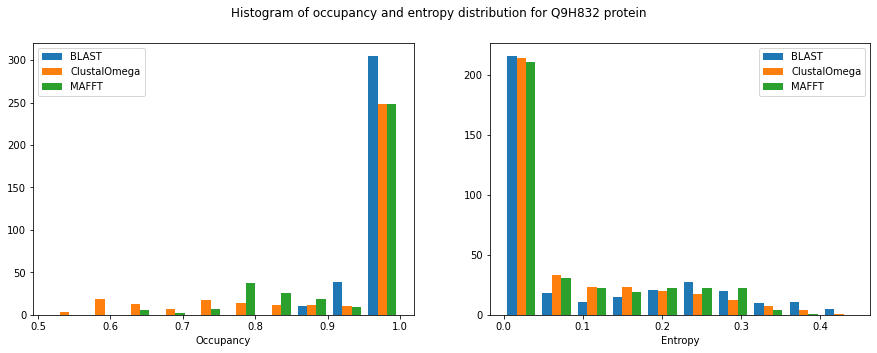

In [14]:
# Histogram of occupancy/entropy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.hist([blast_calc['occupancy'], clustal_calc['occupancy'], mafft_calc['occupancy']])
ax2.hist([blast_calc['entropy'], clustal_calc['entropy'], mafft_calc['entropy']])

ax1.legend(['BLAST', 'ClustalOmega', 'MAFFT'])
ax2.legend(['BLAST', 'ClustalOmega', 'MAFFT'])

ax1.set_xlabel('Occupancy')
ax2.set_xlabel('Entropy')

plt.suptitle(f'Histogram of occupancy and entropy distribution for {id} protein')
plt.show()

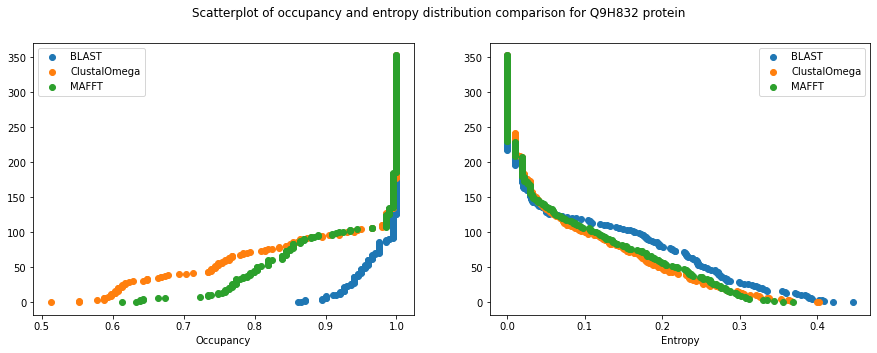

In [15]:
# Scatterplot of occupancy/entropy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.scatter(np.sort(blast_calc['occupancy']), blast_calc['pos'])
ax1.scatter(np.sort(clustal_calc['occupancy']), clustal_calc['pos'])
ax1.scatter(np.sort(mafft_calc['occupancy']), mafft_calc['pos'])

ax2.scatter(np.sort(blast_calc['entropy']), blast_calc['pos'][::-1])
ax2.scatter(np.sort(clustal_calc['entropy']), clustal_calc['pos'][::-1])
ax2.scatter(np.sort(mafft_calc['entropy']), mafft_calc['pos'][::-1])

ax1.legend(['BLAST', 'ClustalOmega', 'MAFFT'])
ax2.legend(['BLAST', 'ClustalOmega', 'MAFFT'])
ax1.set_xlabel('Occupancy')
ax2.set_xlabel('Entropy')
plt.suptitle(f'Scatterplot of occupancy and entropy distribution comparison for {id_dis} protein')
plt.show()

### 4.2. Calculation of occupancy and entropy for disordered regions of MSA

#### 4.2.1 Occupancy and entropy for several disordered regions

In [487]:
# Calculate occupancy and entropy for the 1st disordered region
dis_calc0 = stats_calculation(dis_seqs[0])
dis_calc0.head()

,pos,occupancy,entropy,counts
0,0,1.0,0.0,"[(G, 1)]"
1,1,1.0,0.0,"[(T, 1)]"
2,2,1.0,0.0,"[(P, 1)]"
3,3,1.0,0.0,"[(R, 1)]"
4,4,1.0,0.0,"[(G, 1)]"


In [488]:
# Calculate occupancy and entropy for the 2nd disordered region
dis_calc1 = stats_calculation(dis_seqs[1])
dis_calc1.head()

,pos,occupancy,entropy,counts
0,0,1.0,0.0,"[(G, 1)]"
1,1,1.0,0.0,"[(A, 1)]"
2,2,1.0,0.0,"[(P, 1)]"
3,3,1.0,0.0,"[(R, 1)]"
4,4,1.0,0.0,"[(G, 1)]"


/Users/alina/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


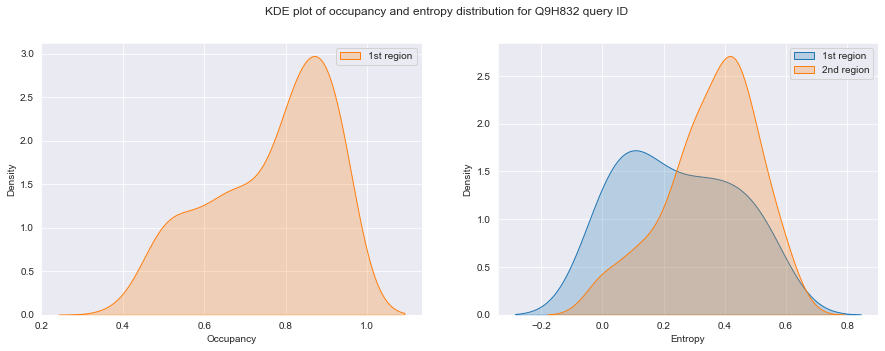

In [47]:
# KDE plot of occupancy and entropy distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.kdeplot(dis_calc0['occupancy'], shade = True, ax = ax1)
sns.kdeplot(dis_calc1['occupancy'], shade = True, ax = ax1)
# sns.kdeplot(dis_calc2['occupancy'], shade = True, ax = ax1)

sns.kdeplot(dis_calc0['entropy'], shade = True, ax = ax2)
sns.kdeplot(dis_calc1['entropy'], shade = True, ax = ax2)
# sns.kdeplot(dis_calc2['entropy'], shade = True, ax = ax2)

ax1.legend(['1st region', '2nd region', '3rd region'])
ax2.legend(['1st region', '2nd region', '3rd region'])
ax1.set_xlabel('Occupancy')
ax2.set_xlabel('Entropy')
plt.suptitle(f'KDE plot of occupancy and entropy distribution for {id_dis} query ID')
plt.show()

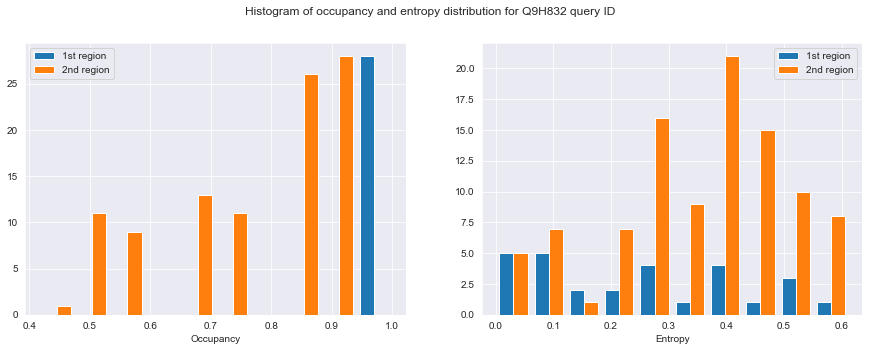

In [49]:
# Barplot of occupancy and entropy distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.hist([dis_calc0['occupancy'], dis_calc1['occupancy'],
          # dis_calc2['occupancy']
         ])
ax2.hist([dis_calc0['entropy'], dis_calc1['entropy'],
          # dis_calc2['entropy']
         ])

ax1.legend(['1st region', '2nd region',
            # '3rd region'
           ])
ax2.legend(['1st region', '2nd region',
            # '3rd region'
           ])

ax1.set_xlabel('Occupancy')
ax2.set_xlabel('Entropy')

plt.suptitle(f'Histogram of occupancy and entropy distribution for {id_dis} query ID')
plt.show()

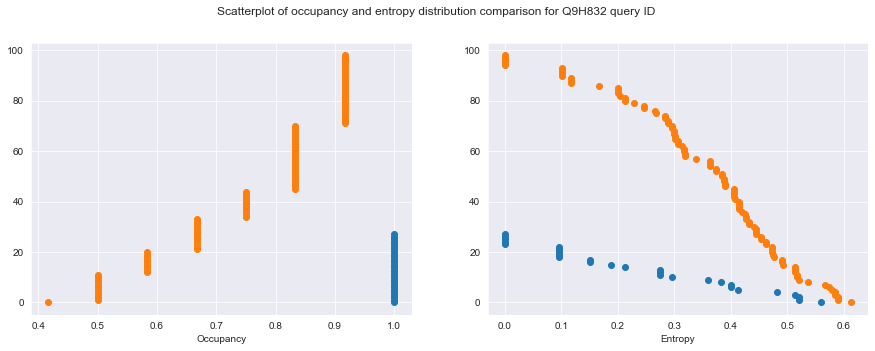

In [50]:
# Scatterplot of occupancy and entropy distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.scatter(np.sort(dis_calc0['occupancy']), dis_calc0['pos'])
ax1.scatter(np.sort(dis_calc1['occupancy']), dis_calc1['pos'])
# ax1.scatter(np.sort(dis_calc2['occupancy']), dis_calc2['pos'])

ax2.scatter(np.sort(dis_calc0['entropy']), dis_calc0['pos'][::-1])
ax2.scatter(np.sort(dis_calc1['entropy']), dis_calc1['pos'][::-1])
# ax2.scatter(np.sort(dis_calc2['entropy']), dis_calc2['pos'][::-1])

ax1.set_xlabel('Occupancy')
ax2.set_xlabel('Entropy')
plt.suptitle(f'Scatterplot of occupancy and entropy distribution comparison for {id_dis} query ID')
plt.show()

#### 4.2.2 Occupancy and entropy for one disordered region

In [489]:
# Calculate occupancy and entropy for the region
dis_calc = stats_calculation(dis_seqs)
dis_calc

,pos,occupancy,entropy,counts
0,0,1.000000,0.032215,"[(G, 50), (V, 1)]"
1,1,1.000000,0.442032,"[(A, 24), (S, 15), (T, 5), (G, 5), (I, 1), (F,..."
2,2,1.000000,0.493429,"[(P, 29), (T, 7), (S, 4), (V, 4), (A, 2), (F, ..."
3,3,1.000000,0.150667,"[(R, 46), (P, 2), (L, 1), (G, 1), (D, 1)]"
4,4,1.000000,0.465166,"[(G, 27), (P, 7), (S, 6), (N, 5), (T, 5), (A, 1)]"
5,5,1.000000,0.593037,"[(G, 20), (E, 9), (D, 8), (S, 5), (T, 2), (N, ..."
6,6,0.882353,0.590985,"[(G, 19), (S, 10), (N, 3), (E, 3), (T, 3), (A,..."
7,7,1.000000,0.551445,"[(S, 25), (A, 9), (Q, 5), (G, 3), (T, 3), (K, ..."
8,8,1.000000,0.594776,"[(G, 18), (S, 10), (E, 7), (D, 6), (A, 4), (Q,..."
9,9,1.000000,0.055226,"[(D, 49), (N, 2)]"


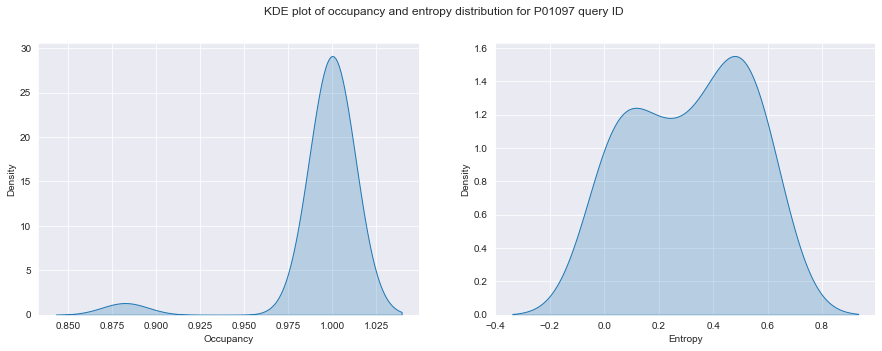

In [490]:
# KDE plot of occupancy and entropy distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.kdeplot(dis_calc['occupancy'], shade = True, ax = ax1)
sns.kdeplot(dis_calc['entropy'], shade = True, ax = ax2)

ax1.set_xlabel('Occupancy')
ax2.set_xlabel('Entropy')
plt.suptitle(f'KDE plot of occupancy and entropy distribution for {id_dis} query ID')
plt.show()

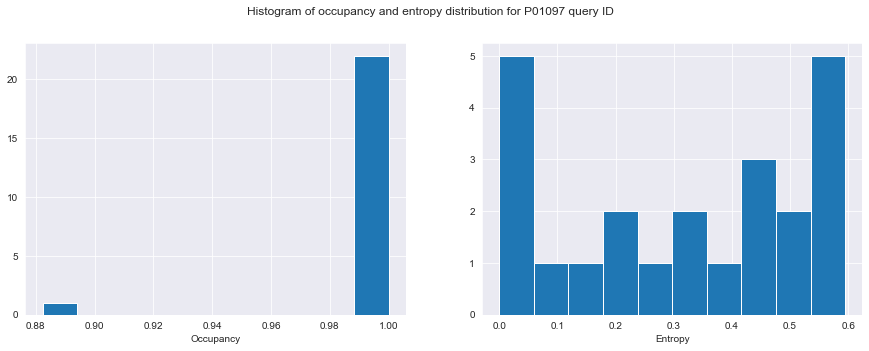

In [491]:
# Barplot of occupancy and entropy distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.hist([dis_calc['occupancy']])
ax2.hist([dis_calc['entropy']])

ax1.set_xlabel('Occupancy')
ax2.set_xlabel('Entropy')

plt.suptitle(f'Histogram of occupancy and entropy distribution for {id_dis} query ID')
plt.show()

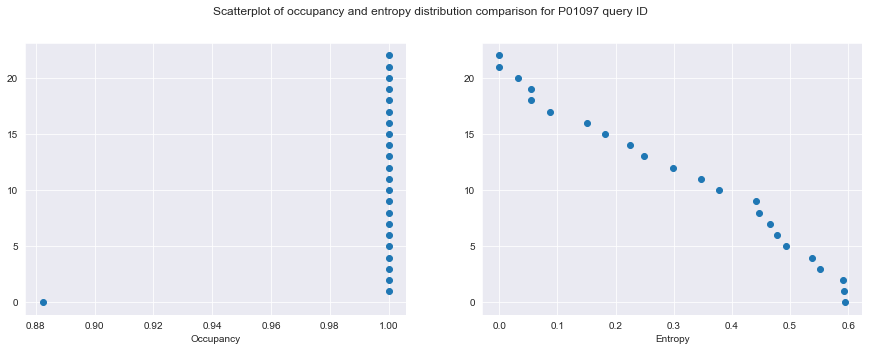

In [492]:
# Scatterplot of occupancy and entropy distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.scatter(np.sort(dis_calc['occupancy']), dis_calc['pos'])
ax2.scatter(np.sort(dis_calc['entropy']), dis_calc['pos'][::-1])

ax1.set_xlabel('Occupancy')
ax2.set_xlabel('Entropy')
plt.suptitle(f'Scatterplot of occupancy and entropy distribution comparison for {id_dis} query ID')
plt.show()